<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/book2/06/simulated_annealing_2d_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulated annealing on a 2d surface

Code is based on

https://krischer.github.io/seismo_live_build/html/Seismic%20Inverse%20Problems/Probabilistic%20Inversion/pi_simann_wrapper.html

and modified by murphyk@, Neoanarika@

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from IPython import display

try:
    import probml_utils as pml
except:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml
    
    
from mpl_toolkits.mplot3d import Axes3D
import warnings
# %matplotlib inline

Note: you may need to restart the kernel to use updated packages.


# Target distribution

We use  the [peaks](https://www.mathworks.com/help/matlab/ref/peaks.html) function from matlab, modified so it is positive:
$$
p(x,y) \propto  |3 (1-x)^2 e^{-x^2 - (y+1)^2}  
   - 10 (\frac{x}{5} - x^3 - y^5) e^{-x^2 -y^2} 
   - \frac{1}{3} e^{-(x+1)^2 - y^2} |
$$


In [2]:
def abs_peaks_func(x,y):
    # in contrast to the peaks function: all negative values are multiplied by (-1)
    return jnp.abs(3.0 * (1 - x) ** 2 * jnp.exp(-(x**2) - (y + 1) ** 2) - 10.0 * (x / 5 - x**3 - y**5) * jnp.exp(-(x**2) - y**2) - 1.0 / 3 * jnp.exp(-((x + 1) ** 2) - y**2))

In [3]:
# Generate a pdf

# the following steps generate a pdf; this is equivalent to the function "peaks(n)" in matlab
n = 100 # number of dimension
pdf = np.zeros([n, n])
sigma = jnp.zeros([n, n])
# s = jnp.zeros([n, n])
x = -3.0
for i in range(0, n):
    y = -3.0
    for j in range(0, n):
        pdf[j,i] = abs_peaks_func(x,y)
        y = y + 6.0 / (n - 1)
    x = x + 6.0 / (n - 1)

pdf = jnp.array(pdf)
pdf = pdf / pdf.max()
energy = -jnp.log(pdf)

In [4]:
def plot_3d_surface(x,y,pdf,title = None,fig_name = None):
    fig = plt.figure()
    ax = fig.gca(projection="3d")
    x, y = jnp.meshgrid(x, y)
    surf = ax.plot_surface(y, x, pdf, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.1)
    if fig_name:
        pml.savefig(fig_name)
    
    if title:
        ax.set_title(title)
    plt.tight_layout()

/home/patel_zeel/miniconda3/envs/py3713_2/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  This is separate from the ipykernel package so we can avoid doing imports until
/home/patel_zeel/Probml_karm/probml-utils/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


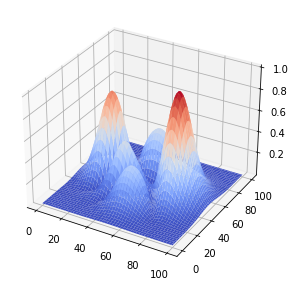

In [5]:
#Plot the 3D plot of pdf
#--------------------------
# %matplotlib inline
X = jnp.arange(0, 100 + 100.0 / (n - 1), 100.0 / (n - 1))
Y = jnp.arange(0, 100 + 100.0 / (n - 1), 100.0 / (n - 1))
plot_3d_surface(Y,X,pdf,fig_name="sim_anneal_2d_peaks_latexified.pdf")

/home/patel_zeel/miniconda3/envs/py3713_2/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  This is separate from the ipykernel package so we can avoid doing imports until


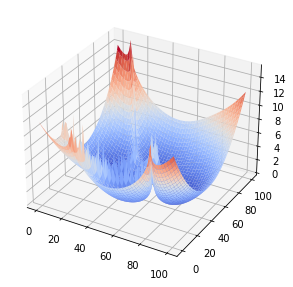

In [9]:
# Plot the 3D plot of Energy function
# --------------------------
plot_3d_surface(X,Y,energy,fig_name="sim_anneal_2d_energy")

# Heat bath

The "heat bath" refers to a modified version of the distribution in which we vary the temperature. 

/home/patel_zeel/miniconda3/envs/py3713_2/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  This is separate from the ipykernel package so we can avoid doing imports until


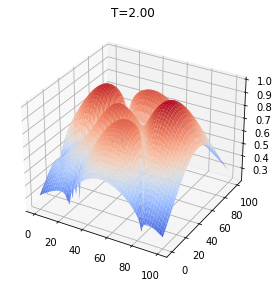

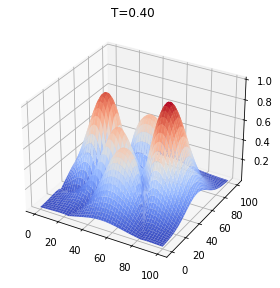

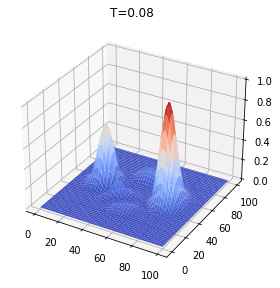

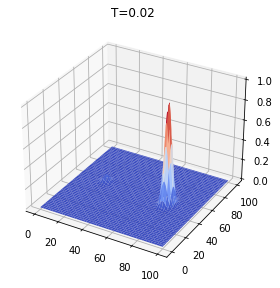

In [10]:
temperature = 10  # initial temperature for the plots
stepT = 4  # how many steps should the Temperature be *0.2  for
x = np.arange(0, 100 + 100.0 / (n - 1), 100.0 / (n - 1))
y = np.arange(0, 100 + 100.0 / (n - 1), 100.0 / (n - 1))
for i in range(0, stepT):
    sigma = np.exp(-(energy) / temperature)
    sigma = sigma / sigma.max()
    ttl = "T={:0.2f}".format(temperature)
    temperature = temperature * 0.2
    plot_3d_surface(x,y,sigma,title="T={:0.2f}".format(temperature),fig_name=f"sim_anneal_2d_cooled{i}")


# SA algorithm

In [11]:
def sim_anneal(proposal="gaussian", sigma=10, seed = jax.random.PRNGKey(0)):
    #jnp.random.seed(42)
    seed1,seed2 = jax.random.split(seed)
    x_start = jnp.array([jnp.floor(jax.random.uniform(seed1,minval=0, maxval=100)), jnp.floor(jax.random.uniform(seed2,minval=0, maxval=100))]) # x_start
    xcur = x_start.astype(int) # x current
    n_samples = 300  # number of samples to keep
    T = 1  # start temperature
    alpha = 0.99  # cooling schedule

    # list of visited points, temperatures, probabilities
    x_hist = xcur  # will be (N,2) array
    prob_hist = []
    temp_hist = []

    nreject = 0
    iis = 0  # number of accepted points
    n_proposed_points = 0  # num proposed points
    while n_proposed_points < n_samples:
        _,seed = jax.random.split(seed)
        n_proposed_points = n_proposed_points + 1
        if proposal == "uniform":
            seeds = jax.random.split(seed)
            xnew = jnp.array([jnp.floor(jax.random.uniform(seeds[0],minval=0, maxval=100)), jax.random.uniform(seeds[1],minval=0, maxval=100)])
            #print(xnew)
        elif proposal == "gaussian":
            xnew = xcur + jax.random.normal(seed,shape=(2,)) * sigma
            xnew = jnp.maximum(xnew, 0)
            xnew = jnp.minimum(xnew, 99)
        else:
            raise ValueError("Unknown proposal")
        xnew = xnew.astype(int)

        # compare energies
        Ecur = energy[xcur[0], xcur[1]]
        Enew = energy[xnew[0], xnew[1]]
        deltaE = Enew - Ecur
        #print([n_proposed_points, xcur, xnew, Ecur, Enew, deltaE])

        temp_hist.append(T)
        T = alpha * T
        p_accept = jnp.exp(-1.0 * deltaE / T)
        #print(p_accept)
        p_accept = min(1, p_accept)
        test = jax.random.uniform(jax.random.split(seed)[0],minval=0, maxval=1)
        #print(test)
        if test <= p_accept:
            xcur = xnew
            iis = iis + 1
        else:
            nreject += 1

        x_hist = jnp.vstack((x_hist, xcur))
        prob_hist.append(pdf[xcur[0], xcur[1]])

    n_proposed_points = n_proposed_points + 1
    print(f"jnproposed {n_proposed_points}, naccepted {iis}, nreject {nreject}")
    return x_hist, prob_hist, temp_hist


# Run experiments

In [12]:
pml.latexify(width_scale_factor=3, fig_height=1.3)

/home/patel_zeel/Probml_karm/probml-utils/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


In [13]:
proposals = ["gaussian","uniform"]
x_hist = {}
prob_hist = {}
temp_hist = {}
for proposal in proposals:
    print(proposal)
    x_hist[proposal], prob_hist[proposal], temp_hist[proposal] = sim_anneal(proposal=proposal,seed=jax.random.PRNGKey(25))

gaussian
jnproposed 301, naccepted 92, nreject 208
uniform
jnproposed 301, naccepted 33, nreject 267


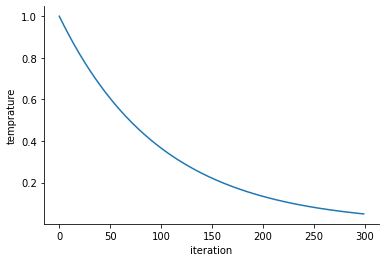

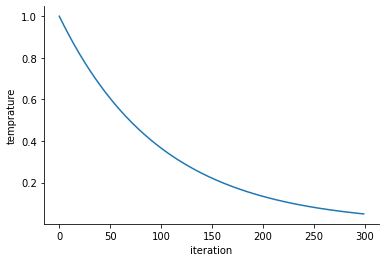

In [14]:
for proposal in proposals:
    plt.figure()
    plt.plot(temp_hist[proposal])
    plt.xlabel("iteration")
    plt.ylabel("temprature")
    #plt.title("temperature vs time")
    #plt.tight_layout()
    sns.despine()
    pml.savefig(f"sim_anneal_2d_temp_vs_time_{proposal}.pdf")
plt.show()

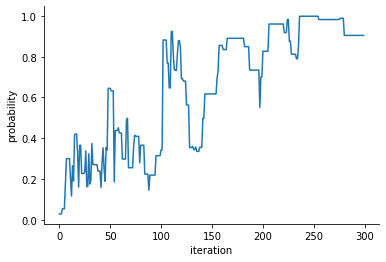

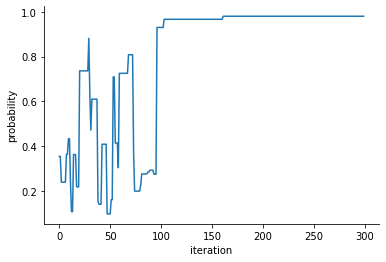

In [15]:
for proposal in proposals:
    plt.figure()
    plt.plot(prob_hist[proposal])
    plt.xlabel("iteration")
    plt.ylabel("probability")
    sns.despine()
    pml.savefig(f"sim_anneal_2d_prob_vs_time_{proposal}.pdf")

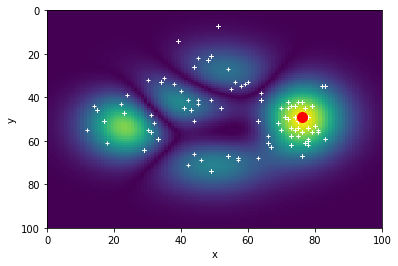

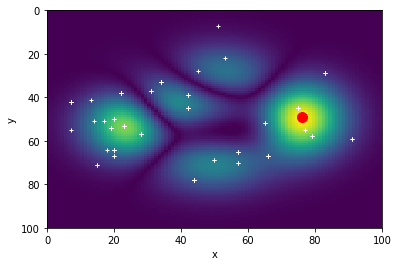

In [16]:
# Plot points visited
global_markersize = 5 if pml.is_latexify_enabled() else 10
step_markersize = 2 if pml.is_latexify_enabled() else 4
for proposal in proposals:
    probs = prob_hist[proposal]
    xa = x_hist[proposal]

    f1, ax = plt.subplots()
    ax.imshow(pdf.transpose(), aspect="auto", extent=[0, 100, 100, 0], interpolation="none")

    # Maximum value achieved ploted with white cirlce
    # maxi = np.argmax(probs) # index of best model
    # ax.plot(xa[maxi,0],xa[maxi,1],'wo', markersize=10)

    # Starting point with white cirlce
    #ax.plot(xa[0, 0], xa[0, 1], "ro", markersize=10)

    # Global maximm with red cirlce
    ind = np.unravel_index(np.argmax(pdf, axis=None), pdf.shape)
    
    ax.plot(xa[:, 0], xa[:, 1], "w+",label="steps",markersize=step_markersize)  # Plot the steps with white +4
    ax.plot(ind[0], ind[1], "ro", markersize=global_markersize,label="global maxima")

    ax.set_ylabel("y")
    ax.set_xlabel("x")
    #plt.legend(framealpha=0.5)
    pml.savefig(f"sim_anneal_2d_samples_{proposal}.pdf")
    